# **BERT版本（最終版本）**

In [1]:
import os
import torch
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from google.colab import auth 
from datetime import datetime
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### **開啟tensorflow和GPU**

In [3]:
!nvidia-smi

Sat Feb 20 03:32:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [5]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Tools information

## tools version
* transformer==4.1.1
* tensorflow==2.4.0
* tensorflow_hub==0.11.0
* keras==2.4.3
* sklearn==0.22.2.post1
* torch==1.7.0+cu101

## pytorch install commend

* !pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [6]:
!pip install transformers==4.1.1
# !pip install tensorflow_gpu==2.4.0

     |████████████████████████████████| 1.5MB 15.1MB/s 
     |████████████████████████████████| 2.9MB 31.6MB/s 
     |████████████████████████████████| 890kB 51.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=92edadd6c3f10edb56da8c6b9821365ca128a3195123a98f261cf936f068aaba
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [7]:
print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)
print("keras version : ", keras.__version__)

tensorflow version :  2.4.1
tensorflow_hub version :  0.11.0
keras version :  2.4.3


### **匯入訓練資料**

In [8]:
# All trainingdata
# https://drive.google.com/file/d/1JwrWwFzen3Z9iwHpDEvA1gXiYnw8DftE/view?usp=sharing
# 如果不能直接跑，需要自行下載，上傳自己的雲端，在複製後面的「連結ID」到下方「file_id = 」的地方改掉即可（如上面連結的ID即是「1JwrWwFzen3Z9iwHpDEvA1gXiYnw8DftE」）

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1JwrWwFzen3Z9iwHpDEvA1gXiYnw8DftE'  #雲端硬碟檔案連結碼
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('final_input_new.csv')
data = pd.read_csv('final_input_new.csv')

print(data)

                         id  ...                                     Topic_Keywords
0       1223138845933195264  ...  virus, test, infect, coronavirus, positive, ma...
1       1223138845916426240  ...  outbreak, coronavirus, world, due, country, ch...
2       1223138845740425219  ...  health, public, global, emergency, week, trave...
3       1223138845568335873  ...  government, quarantine, student, ship, citizen...
4       1223138845329412096  ...  spread, year, evil, pandemic, stop, human, pro...
...                     ...  ...                                                ...
119309  1227831962422763521  ...  health, public, global, emergency, week, trave...
119310  1227831961017708544  ...  health, public, global, emergency, week, trave...
119311  1227831955875495937  ...  patient, hospital, affiliate, mask, medical, v...
119312  1227831951853142016  ...  people, chinese, spread, medium, die, virus, d...
119313  1227831945972850688  ...  case, death, confirm, report, number, toll

In [9]:
data.columns

Index(['id', 'created_at', 'from_user_tweetcount', 'from_user_followercount',
       'from_user_friendcount', 'from_user_id', 'to_user_id', 'text', 'lang',
       'truncated', 'from_user_verified', 'retweet_count', 'favorite_count',
       'url', 'hashtag', 'mention', 'text_clean', 'text_wiz_hashtag_number',
       'Dominant_Topic', 'Topic_Keywords'],
      dtype='object')

In [10]:
data_copy = data
data

id  ...                                     Topic_Keywords
0       1223138845933195264  ...  virus, test, infect, coronavirus, positive, ma...
1       1223138845916426240  ...  outbreak, coronavirus, world, due, country, ch...
2       1223138845740425219  ...  health, public, global, emergency, week, trave...
3       1223138845568335873  ...  government, quarantine, student, ship, citizen...
4       1223138845329412096  ...  spread, year, evil, pandemic, stop, human, pro...
...                     ...  ...                                                ...
119309  1227831962422763521  ...  health, public, global, emergency, week, trave...
119310  1227831961017708544  ...  health, public, global, emergency, week, trave...
119311  1227831955875495937  ...  patient, hospital, affiliate, mask, medical, v...
119312  1227831951853142016  ...  people, chinese, spread, medium, die, virus, d...
119313  1227831945972850688  ...  case, death, confirm, report, number, toll, to...

[119314 rows x 20 columns]

In [11]:
data['x'] = data['text_clean']
data['y'] = data['Dominant_Topic']

In [12]:
data['y'].value_counts()

0    16399
2    13704
8    13094
7    13038
3    12859
4    12779
6    10052
1     9733
5     9474
9     8182
Name: y, dtype: int64

In [13]:
#data, data1 = train_test_split(data,random_state=8467, test_size=0.2)

# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold
# data sample
# prepare cross validation
kfold = KFold(5, True, 1)
# enumerate splits
trainset = []
testset = []
for train, test in kfold.split(data):
  trainset.append(train)
  testset.append(test)
	#print('train: %s, test: %s' % (train, test))

In [14]:
# #data, data1 = train_test_split(data,random_state=8467, test_size=0.2)

# trainList = trainset[1]
# testList = testset[1]
# data_train = data.iloc[trainList]
# data_test = data.iloc[testList]

In [15]:
# use all data
data_train = data.copy()

In [16]:
data_train

id  ...  y
0       1223138845933195264  ...  3
1       1223138845916426240  ...  5
2       1223138845740425219  ...  6
3       1223138845568335873  ...  2
4       1223138845329412096  ...  8
...                     ...  ... ..
119309  1227831962422763521  ...  6
119310  1227831961017708544  ...  6
119311  1227831955875495937  ...  7
119312  1227831951853142016  ...  1
119313  1227831945972850688  ...  0

[119314 rows x 22 columns]

In [16]:
# data_test

In [17]:
sentences = data_train['x']
labels = data_train['y']

### **匯入BERT的word embedding(使用bert-base-chinese)**

In [18]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
#tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

Loading BERT tokenizer...


In [19]:
# Print the original sentence.
print(' Original: ', sentences[10])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[10]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[10])))

 Original:  NO QUARANTINE SET ON FLIGHTS FROM CHINA, NO PLANS IN PLACE- Trudeau avoids directly answering all questions, refuses any details, has made no decisions or plans Why the WHO declared a global health emergency Infectious disease expert Dr. Neil Rau explains why the WHO decided to declare the new coronavirus a global health emergency. ctvnews.ca
Tokenized:  ['no', 'qua', '##ranti', '##ne', 'set', 'on', 'flights', 'from', 'china', ',', 'no', 'plans', 'in', 'place', '-', 'tr', '##ude', '##au', 'avoid', '##s', 'directly', 'answer', '##ing', 'all', 'questions', ',', 'refuses', 'any', 'details', ',', 'has', 'made', 'no', 'decisions', 'or', 'plans', 'why', 'the', 'who', 'declared', 'a', 'global', 'health', 'emergency', 'in', '##fect', '##ious', 'disease', 'expert', 'dr', '.', 'nei', '##l', 'ra', '##u', 'explains', 'why', 'the', 'who', 'decided', 'to', 'de', '##cla', '##re', 'the', 'new', 'corona', '##vir', '##us', 'a', 'global', 'health', 'emergency', '.', 'c', '##t', '##vne', '##ws

### **做word embedding**

In [20]:
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        max_length = 128,     
                        truncation=True     # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
#print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Token IDs: [101, 10105, 10319, 10124, 47489, 25609, 10230, 15130, 10105, 92991, 14819, 10347, 10105, 16298, 10108, 17446, 42663, 10841, 25626, 10114, 10105, 11406, 27636, 168, 47620, 31206, 37715, 10251, 14424, 131, 58768, 10138, 169, 110102, 41256, 11084, 10751, 20399, 117, 47306, 10338, 10115, 10105, 31206, 37715, 10251, 10319, 10124, 47489, 25609, 10230, 15130, 10105, 92991, 14819, 10347, 10105, 16298, 10108, 17446, 42663, 10841, 25626, 10114, 10105, 58768, 10138, 117, 49871, 10529, 10338, 17021, 119, 47620, 119, 11170, 119, 16803, 102]


In [21]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  128


In [22]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 128

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 128 values...

Padding token: "[PAD]", ID: 0

Done.


In [23]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [24]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=8467, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=8467, test_size=0.1)

In [25]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.from_numpy(np.array(train_labels))
validation_labels = torch.from_numpy(np.array(validation_labels))

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [26]:
train_labels [1:100]

tensor([0, 0, 1, 6, 2, 1, 2, 5, 1, 6, 0, 1, 7, 1, 1, 3, 5, 2, 6, 9, 0, 8, 9, 5,
        7, 7, 5, 0, 6, 6, 4, 0, 9, 5, 7, 7, 2, 4, 8, 8, 8, 2, 8, 6, 9, 7, 6, 0,
        7, 1, 8, 7, 6, 0, 0, 2, 7, 4, 2, 4, 8, 0, 2, 2, 0, 4, 8, 3, 8, 7, 4, 4,
        4, 2, 3, 4, 3, 6, 0, 1, 5, 8, 0, 0, 6, 3, 5, 5, 7, 8, 5, 2, 8, 7, 1, 3,
        2, 6, 3])

In [27]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### **進行模型設定：使用bert-base-chinese，label設定為3**


In [28]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
#bert-base-multilingual-cased
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 10, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [29]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
 
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
 
print('==== Embedding Layer ====\n')
 
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
 
print('\n==== First Transformer ====\n')
 
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
 
print('\n==== Output Layer ====\n')
 
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

### **設定優化器：lr = 2e-5**

In [30]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [31]:
from transformers import get_linear_schedule_with_warmup
 
# Number of training epochs (authors recommend between 2 and 4)
epochs = 4
 
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
 
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [32]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [33]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


### **訓練模型，epoch設定為4**

In [34]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  3,356.    Elapsed: 0:00:26.
  Batch    80  of  3,356.    Elapsed: 0:00:53.
  Batch   120  of  3,356.    Elapsed: 0:01:20.
  Batch   160  of  3,356.    Elapsed: 0:01:47.
  Batch   200  of  3,356.    Elapsed: 0:02:15.
  Batch   240  of  3,356.    Elapsed: 0:02:42.
  Batch   280  of  3,356.    Elapsed: 0:03:10.
  Batch   320  of  3,356.    Elapsed: 0:03:38.
  Batch   360  of  3,356.    Elapsed: 0:04:05.
  Batch   400  of  3,356.    Elapsed: 0:04:33.
  Batch   440  of  3,356.    Elapsed: 0:05:02.
  Batch   480  of  3,356.    Elapsed: 0:05:30.
  Batch   520  of  3,356.    Elapsed: 0:05:58.
  Batch   560  of  3,356.    Elapsed: 0:06:26.
  Batch   600  of  3,356.    Elapsed: 0:06:54.
  Batch   640  of  3,356.    Elapsed: 0:07:22.
  Batch   680  of  3,356.    Elapsed: 0:07:50.
  Batch   720  of  3,356.    Elapsed: 0:08:19.
  Batch   760  of  3,356.    Elapsed: 0:08:47.
  Batch   800  of  3,356.    Elapsed: 0:09:15.
  Batch   840  of

In [ ]:
# save model

torch.save(model, "model_all_new.pth")
files.download('model_all_new.pth')

### **針對loss畫出時序圖**

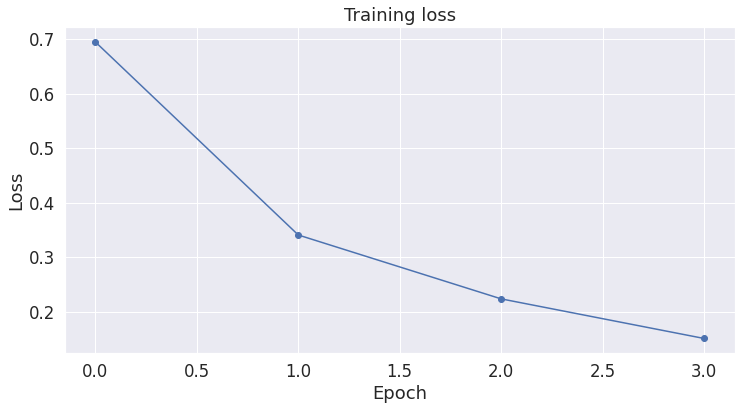

<Figure size 864x432 with 0 Axes>

In [35]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()
plt.savefig('loss.png')

# import matplotlib.pyplot as plt
# % matplotlib inline

# import seaborn as sns

# # Use plot styling from seaborn.
# sns.set(style='darkgrid')

# # Increase the plot size and font size.
# sns.set(font_scale=1.5)
# plt.rcParams["figure.figsize"] = (12,6)

# # Plot the learning curve.
# plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
# plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# # Label the plot.
# plt.title("Training & Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.xticks([1, 2, 3, 4])

# plt.show()


In [ ]:
files.download('loss.png')

In [70]:
# data_test = data_test.dropna(subset=['x'])
# data_test['x'] = data_test.x.apply(lambda x: str(x))

In [71]:
# data_test

In [68]:
# data_sample = data_test.copy()

In [69]:
# data_sample

In [67]:
# import pandas as pd
# # Create sentence and label lists
# sentences = data_sample['x']
# labels = data_test['y']

### **設定測試集**

In [66]:
# MAX_LEN

In [ ]:
# # Tokenize all of the sentences and map the tokens to thier word IDs.
# input_ids = []

# # For every sentence...
# for sent in sentences:
#     # `encode` will:
#     #   (1) Tokenize the sentence.
#     #   (2) Prepend the `[CLS]` token to the start.
#     #   (3) Append the `[SEP]` token to the end.
#     #   (4) Map tokens to their IDs.
#     encoded_sent = tokenizer.encode(
#                         sent,                      # Sentence to encode.
#                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                    )
    
#     input_ids.append(encoded_sent)

# # Pad our input tokens
# input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
#                           dtype="long", truncating="post", padding="post")

# # Create attention masks
# attention_masks = []

# # Create a mask of 1s for each token followed by 0s for padding
# for seq in input_ids:
#   seq_mask = [float(i>0) for i in seq]
#   attention_masks.append(seq_mask) 

# # Convert to tensors.
# prediction_inputs = torch.tensor(input_ids)
# prediction_masks = torch.tensor(attention_masks)
# #prediction_labels = torch.from_numpy(np.array(labels))

# # Set the batch size.  
# batch_size = 32

# # Create the DataLoader.
# #prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
# prediction_data = TensorDataset(prediction_inputs, prediction_masks)
# prediction_sampler = SequentialSampler(prediction_data)
# prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### **Predict測試集**

In [ ]:
# # Prediction on test set

# print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# # Put model in evaluation mode
# model.eval()

# # Tracking variables 
# #predictions , true_labels = [], []
# predictions = []

# # Predict 
# for batch in prediction_dataloader:
#   # Add batch to GPU
#   batch = tuple(t.to(device) for t in batch)
  
#   # Unpack the inputs from our dataloader
#   #b_input_ids, b_input_mask, b_labels = batch
#   b_input_ids, b_input_mask = batch

  
#   # Telling the model not to compute or store gradients, saving memory and 
#   # speeding up prediction
#   with torch.no_grad():
#       # Forward pass, calculate logit predictions
#       outputs = model(b_input_ids, token_type_ids=None, 
#                       attention_mask=b_input_mask)

#   logits = outputs[0]

#   # Move logits and labels to CPU
#   logits = logits.detach().cpu().numpy()
#   #label_ids = b_labels.to('cpu').numpy()
  
#   # Store predictions and true labels
#   predictions.append(logits)
#   #true_labels.append(label_ids)

# print('    DONE.')

### **評斷（用原先資料拿10%當虛擬測試集測試之結果）**

In [65]:
# from sklearn.metrics import matthews_corrcoef

# matthews_set = []

# # Evaluate each test batch using Matthew's correlation coefficient
# print('Calculating Matthews Corr. Coef. for each batch...')

# # For each input batch...
# for i in range(len(true_labels)):
  
#   # The predictions for this batch are a 2-column ndarray (one column for "0" 
#   # and one column for "1"). Pick the label with the highest value and turn this
#   # in to a list of 0s and 1s.
#   pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
#   # Calculate and store the coef for this batch.  
#   matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
#   matthews_set.append(matthews)

In [64]:
# # Create a barplot showing the MCC score for each batch of test samples.
# ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

# plt.title('MCC Score per Batch')
# plt.ylabel('MCC Score (-1 to +1)')
# plt.xlabel('Batch #')

# plt.show()

In [63]:
# # Combine the predictions for each batch into a single list of 0s and 1s.
# flat_predictions = [item for sublist in predictions for item in sublist]
# flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# # Combine the correct labels for each batch into a single list.
# flat_true_labels = [item for sublist in true_labels for item in sublist]

# # Calculate the MCC
# mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

# print('MCC: %.3f' % mcc)

In [62]:
# # Combine the predictions for each batch into a single list of 0s and 1s.
# flat_predictions = [item for sublist in predictions for item in sublist]
# flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [61]:
# from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
# accuracy = accuracy_score(flat_true_labels, flat_predictions)
# precision = precision_score(flat_true_labels, flat_predictions, average='macro')
# recall = recall_score(flat_true_labels, flat_predictions, average='macro')
# fscore = f1_score(flat_true_labels, flat_predictions, average='macro')

# print("Accuracy: %g\tPrecision: %g\tRecall: %g\tF-score: %g" % (
#     accuracy, precision, recall, fscore))



### **跑出最終測試集結果**

In [59]:
# # Combine the predictions for each batch into a single list of 0s and 1s.
# flat_predictions = [item for sublist in predictions for item in sublist]
# flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [60]:
# flat_predictions[0:99]

In [58]:
# data_new = data_sample

In [57]:
# data_new.head()

In [56]:
# data_new['pred'] = flat_predictions

In [55]:
# data_new.head()

In [ ]:
# accuracy = accuracy_score(data_new['y'], data_new['pred'])
# precision = precision_score(data_new['y'], data_new['pred'], average='macro')
# recall = recall_score(data_new['y'], data_new['pred'], average='macro')
# fscore = f1_score(data_new['y'], data_new['pred'], average='macro')

# print("Accuracy: %g\tPrecision: %g\tRecall: %g\tF-score: %g" % (
#     accuracy, precision, recall, fscore))

Accuracy: 0.882957	Precision: 0.877057	Recall: 0.879099	F-score: 0.877666


In [ ]:
# data_new.to_csv('Hashtag_pred_p2.csv') 
# files.download('Hashtag_pred_p2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# len(data_new)

23863

## Predict data

In [38]:
data_pred = data_train.copy()
data_pred = data_pred.drop(['x','y'],axis=1)

sentences = data_pred['text_clean']

In [46]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
#prediction_labels = torch.from_numpy(np.array(labels))

# Set the batch size.  
batch_size = 32

# Create the DataLoader.
#prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


In [49]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
#predictions , true_labels = [], []
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  #b_input_ids, b_input_mask, b_labels = batch
  b_input_ids, b_input_mask = batch

  # move input and indices to device(CPU)
  # add .long() to prevent[Expected tensor for argument #1 'indices' to have scalar type Long; but got torch.IntTensor instead]
  b_input_ids = b_input_ids.to(device).long()
  b_input_mask = b_input_mask.to(device).long()
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  #label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  #true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 119,314 test sentences...
    DONE.


In [50]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [51]:
data_pred['pred'] = flat_predictions

In [52]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
accuracy = accuracy_score(data_pred['Dominant_Topic'], data_pred['pred'])
precision = precision_score(data_pred['Dominant_Topic'], data_pred['pred'], average='macro')
recall = recall_score(data_pred['Dominant_Topic'], data_pred['pred'], average='macro')
fscore = f1_score(data_pred['Dominant_Topic'], data_pred['pred'], average='macro')

print("Accuracy: %g\tPrecision: %g\tRecall: %g\tF-score: %g" % (
    accuracy, precision, recall, fscore))

Accuracy: 0.96562	Precision: 0.963448	Recall: 0.96416	F-score: 0.963773


In [53]:
# save predictions

data_pred.to_csv('hashtag_pred.csv',index=False) 
files.download('hashtag_pred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>